<a href="https://colab.research.google.com/github/mmukhta3-ai/Advance-Machine-Learning-BA-64061-002-/blob/main/AML_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import subprocess

def install_package(package):
    try:
        subprocess.check_call(["pip", "install", package, "--upgrade", "-q"])
        print(f"Successfully installed/upgraded {package}")
    except subprocess.CalledProcessError as e:
        print(f"Error installing/upgrading {package}: {e}")
        print(e.stdout.decode() if e.stdout else "")
        print(e.stderr.decode() if e.stderr else "")

install_package("keras")
install_package("keras-hub==0.21.1") # Fix specific version for keras-nlp compatibility

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "jax"

In [ ]:
# @title
import os
from IPython.core.magic import register_cell_magic

@register_cell_magic
def backend(line, cell):
    current, required = os.environ.get("KERAS_BACKEND", ""), line.split()[-1]
    if current == required:
        get_ipython().run_cell(cell)
    else:
        print(
            f"This cell requires the {required} backend. To run it, change KERAS_BACKEND to "
            f"\"{required}\" at the top of the notebook, restart the runtime, and rerun the notebook."
        )

## Text classification

### A brief history of natural language processing

### Preparing text data

In [ ]:
import regex as re

def split_chars(text):
    return re.findall(r".", text)

In [ ]:
chars = split_chars("The quick brown fox jumped over the lazy dog.")
chars[:12]

['T', 'h', 'e', ' ', 'q', 'u', 'i', 'c', 'k', ' ', 'b', 'r']

In [ ]:
def split_words(text):
    return re.findall(r"[\w]+|[.,!?;]", text)

In [ ]:
split_words("The quick brown fox jumped over the dog.")

['The', 'quick', 'brown', 'fox', 'jumped', 'over', 'the', 'dog', '.']

In [ ]:
vocabulary = {
    "[UNK]": 0,
    "the": 1,
    "quick": 2,
    "brown": 3,
    "fox": 4,
    "jumped": 5,
    "over": 6,
    "dog": 7,
    ".": 8,
}
words = split_words("The quick brown fox jumped over the lazy dog.")
indices = [vocabulary.get(word, 0) for word in words]

#### Character and word tokenization

In [ ]:
class CharTokenizer:
    def __init__(self, vocabulary):
        self.vocabulary = vocabulary
        self.unk_id = vocabulary["[UNK]"]

    def standardize(self, inputs):
        return inputs.lower()

    def split(self, inputs):
        return re.findall(r".", inputs)

    def index(self, tokens):
        return [self.vocabulary.get(t, self.unk_id) for t in tokens]

    def __call__(self, inputs):
        inputs = self.standardize(inputs)
        tokens = self.split(inputs)
        indices = self.index(tokens)
        return indices

In [ ]:
import collections

def compute_char_vocabulary(inputs, max_size):
    char_counts = collections.Counter()
    for x in inputs:
        x = x.lower()
        tokens = re.findall(r".", x)
        char_counts.update(tokens)
    vocabulary = ["[UNK]"]
    most_common = char_counts.most_common(max_size - len(vocabulary))
    for token, count in most_common:
        vocabulary.append(token)
    return dict((token, i) for i, token in enumerate(vocabulary))

In [ ]:
class WordTokenizer:
    def __init__(self, vocabulary):
        self.vocabulary = vocabulary
        self.unk_id = vocabulary["[UNK]"]

    def standardize(self, inputs):
        return inputs.lower()

    def split(self, inputs):
        return re.findall(r"[\w]+|[.,!?;]", inputs)

    def index(self, tokens):
        return [self.vocabulary.get(t, self.unk_id) for t in tokens]

    def __call__(self, inputs):
        inputs = self.standardize(inputs)
        tokens = self.split(inputs)
        indices = self.index(tokens)
        return indices

In [ ]:
def compute_word_vocabulary(inputs, max_size):
    word_counts = collections.Counter()
    for x in inputs:
        x = x.lower()
        tokens = re.findall(r"[\w]+|[.,!?;]", x)
        word_counts.update(tokens)
    vocabulary = ["[UNK]"]
    most_common = word_counts.most_common(max_size - len(vocabulary))
    for token, count in most_common:
        vocabulary.append(token)
    return dict((token, i) for i, token in enumerate(vocabulary))

In [ ]:
import keras

filename = keras.utils.get_file(
    origin="https://www.gutenberg.org/files/2701/old/moby10b.txt",
)
moby_dick = list(open(filename, "r"))

vocabulary = compute_char_vocabulary(moby_dick, max_size=100)
char_tokenizer = CharTokenizer(vocabulary)

In [ ]:
print("Vocabulary length:", len(vocabulary))

Vocabulary length: 64


In [ ]:
print("Vocabulary start:", list(vocabulary.keys())[:10])

Vocabulary start: ['[UNK]', ' ', 'e', 't', 'a', 'o', 'n', 'i', 's', 'h']


In [ ]:
print("Vocabulary end:", list(vocabulary.keys())[-10:])

Vocabulary end: ['@', '$', '%', '#', '=', '~', '&', '+', '<', '>']


In [ ]:
print("Line length:", len(char_tokenizer(
   "Call me Ishmael. Some years ago--never mind how long precisely."
)))

Line length: 63


In [ ]:
vocabulary = compute_word_vocabulary(moby_dick, max_size=2_000)
word_tokenizer = WordTokenizer(vocabulary)

In [ ]:
print("Vocabulary length:", len(vocabulary))

Vocabulary length: 2000


In [ ]:
print("Vocabulary start:", list(vocabulary.keys())[:5])

Vocabulary start: ['[UNK]', ',', 'the', '.', 'of']


In [ ]:
print("Vocabulary end:", list(vocabulary.keys())[-5:])

Vocabulary end: ['tambourine', 'subtle', 'perseus', 'elevated', 'repose']


In [ ]:
print("Line length:", len(word_tokenizer(
   "Call me Ishmael. Some years ago--never mind how long precisely."
)))

Line length: 13


#### Subword tokenization

In [ ]:
data = [
    "the quick brown fox",
    "the slow brown fox",
    "the quick brown foxhound",
]

In [ ]:
def count_and_split_words(data):
    counts = collections.Counter()
    for line in data:
        line = line.lower()
        for word in re.findall(r"[\w]+|[.,!?;]", line):
            chars = re.findall(r".", word)
            split_word = " ".join(chars)
            counts[split_word] += 1
    return dict(counts)

counts = count_and_split_words(data)

In [ ]:
counts

{'t h e': 3,
 'q u i c k': 2,
 'b r o w n': 3,
 'f o x': 2,
 's l o w': 1,
 'f o x h o u n d': 1}

In [ ]:
def count_pairs(counts):
    pairs = collections.Counter()
    for word, freq in counts.items():
        symbols = word.split()
        for pair in zip(symbols[:-1], symbols[1:]):
            pairs[pair] += freq
    return pairs

def merge_pair(counts, first, second):
    split = re.compile(rf"(?<!\S){first} {second}(?!\S)")
    merged = f"{first}{second}"
    return {split.sub(merged, word): count for word, count in counts.items()}

for i in range(10):
    pairs = count_pairs(counts)
    first, second = max(pairs, key=pairs.get)
    counts = merge_pair(counts, first, second)
    print(list(counts.keys()))

['t h e', 'q u i c k', 'b r ow n', 'f o x', 's l ow', 'f o x h o u n d']
['th e', 'q u i c k', 'b r ow n', 'f o x', 's l ow', 'f o x h o u n d']
['the', 'q u i c k', 'b r ow n', 'f o x', 's l ow', 'f o x h o u n d']
['the', 'q u i c k', 'br ow n', 'f o x', 's l ow', 'f o x h o u n d']
['the', 'q u i c k', 'brow n', 'f o x', 's l ow', 'f o x h o u n d']
['the', 'q u i c k', 'brown', 'f o x', 's l ow', 'f o x h o u n d']
['the', 'q u i c k', 'brown', 'fo x', 's l ow', 'fo x h o u n d']
['the', 'q u i c k', 'brown', 'fox', 's l ow', 'fox h o u n d']
['the', 'qu i c k', 'brown', 'fox', 's l ow', 'fox h o u n d']
['the', 'qui c k', 'brown', 'fox', 's l ow', 'fox h o u n d']


In [ ]:
def compute_sub_word_vocabulary(dataset, vocab_size):
    counts = count_and_split_words(dataset)

    char_counts = collections.Counter()
    for word in counts:
        for char in word.split():
            char_counts[char] += counts[word]
    most_common = char_counts.most_common()
    vocab = ["[UNK]"] + [char for char, freq in most_common]
    merges = []

    while len(vocab) < vocab_size:
        pairs = count_pairs(counts)
        if not pairs:
            break
        first, second = max(pairs, key=pairs.get)
        counts = merge_pair(counts, first, second)
        vocab.append(f"{first}{second}")
        merges.append(f"{first} {second}")

    vocab = dict((token, index) for index, token in enumerate(vocab))
    merges = dict((token, rank) for rank, token in enumerate(merges))
    return vocab, merges

In [ ]:
class SubWordTokenizer:
    def __init__(self, vocabulary, merges):
        self.vocabulary = vocabulary
        self.merges = merges
        self.unk_id = vocabulary["[UNK]"]

    def standardize(self, inputs):
        return inputs.lower()

    def bpe_merge(self, word):
        while True:
            pairs = re.findall(r"(?<!\S)\S+ \S+(?!\S)", word, overlapped=True)
            if not pairs:
                break
            best = min(pairs, key=lambda pair: self.merges.get(pair, 1e9))
            if best not in self.merges:
                break
            first, second = best.split()
            split = re.compile(rf"(?<!\S){first} {second}(?!\S)")
            merged = f"{first}{second}"
            word = split.sub(merged, word)
        return word

    def split(self, inputs):
        tokens = []
        for word in re.findall(r"[\w]+|[.,!?;]", inputs):
            word = " ".join(re.findall(r".", word))
            word = self.bpe_merge(word)
            tokens.extend(word.split())
        return tokens

    def index(self, tokens):
        return [self.vocabulary.get(t, self.unk_id) for t in tokens]

    def __call__(self, inputs):
        inputs = self.standardize(inputs)
        tokens = self.split(inputs)
        indices = self.index(tokens)
        return indices

In [ ]:
vocabulary, merges = compute_sub_word_vocabulary(moby_dick, 2_000)
sub_word_tokenizer = SubWordTokenizer(vocabulary, merges)

In [ ]:
print("Vocabulary length:", len(vocabulary))

Vocabulary length: 2000


In [ ]:
print("Vocabulary start:", list(vocabulary.keys())[:10])

Vocabulary start: ['[UNK]', 'e', 't', 'a', 'o', 'n', 'i', 's', 'h', 'r']


In [ ]:
print("Vocabulary end:", list(vocabulary.keys())[-7:])

Vocabulary end: ['bright', 'pilot', 'sco', 'ben', 'dem', 'gale', 'ilo']


In [ ]:
print("Line length:", len(sub_word_tokenizer(
   "Call me Ishmael. Some years ago--never mind how long precisely."
)))

Line length: 16


### Sets vs. sequences

#### Loading the IMDb classification dataset

In [ ]:
import os, pathlib, shutil, random

zip_path = keras.utils.get_file(
    origin="https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
    fname="imdb",
    extract=True,
)

imdb_extract_dir = pathlib.Path(zip_path) / "aclImdb"

In [ ]:
for path in imdb_extract_dir.glob("*/*"):
    if path.is_dir():
        print(path)

/root/.keras/datasets/imdb/aclImdb/train/unsup
/root/.keras/datasets/imdb/aclImdb/train/pos
/root/.keras/datasets/imdb/aclImdb/train/neg
/root/.keras/datasets/imdb/aclImdb/test/pos
/root/.keras/datasets/imdb/aclImdb/test/neg


In [ ]:
print(open(imdb_extract_dir / "train" / "pos" / "4077_10.txt", "r").read())

I first saw this back in the early 90s on UK TV, i did like it then but i missed the chance to tape it, many years passed but the film always stuck with me and i lost hope of seeing it TV again, the main thing that stuck with me was the end, the hole castle part really touched me, its easy to watch, has a great story, great music, the list goes on and on, its OK me saying how good it is but everyone will take there own best bits away with them once they have seen it, yes the animation is top notch and beautiful to watch, it does show its age in a very few parts but that has now become part of it beauty, i am so glad it has came out on DVD as it is one of my top 10 films of all time. Buy it or rent it just see it, best viewing is at night alone with drink and food in reach so you don't have to stop the film.<br /><br />Enjoy


In [ ]:
train_dir = pathlib.Path("imdb_train")
test_dir = pathlib.Path("imdb_test")
val_dir = pathlib.Path("imdb_val")

# Remove directories if they already exist to prevent FileExistsError
if test_dir.exists():
    shutil.rmtree(test_dir)
if train_dir.exists():
    shutil.rmtree(train_dir)
if val_dir.exists():
    shutil.rmtree(val_dir)

shutil.copytree(imdb_extract_dir / "test", test_dir)

val_percentage = 0.4  # Validate on 10,000 samples.
for category in ("neg", "pos"):
    src_dir = imdb_extract_dir / "train" / category
    src_files = os.listdir(src_dir)
    random.Random(1337).shuffle(src_files)
    num_val_samples = int(len(src_files) * val_percentage)

    os.makedirs(val_dir / category)
    for file in src_files[:num_val_samples]:
        shutil.copy(src_dir / file, val_dir / category / file)
    os.makedirs(train_dir / category)
    for file in src_files[num_val_samples:]:
        shutil.copy(src_dir / file, train_dir / category / file)

In [ ]:
from keras.utils import text_dataset_from_directory

batch_size = 32
train_ds = text_dataset_from_directory(train_dir, batch_size=batch_size)
val_ds = text_dataset_from_directory(val_dir, batch_size=batch_size)
test_ds = text_dataset_from_directory(test_dir, batch_size=batch_size)

### Set models

#### Training a bag-of-words model

In [ ]:
from keras import layers

max_tokens = 20_000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    split="whitespace",
    output_mode="multi_hot",
)
train_ds_no_labels = train_ds.map(lambda x, y: x)
text_vectorization.adapt(train_ds_no_labels)

bag_of_words_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)
bag_of_words_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)
bag_of_words_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)

In [ ]:
x, y = next(bag_of_words_train_ds.as_numpy_iterator())
x.shape

In [ ]:
y.shape

In [ ]:
def build_linear_classifier(max_tokens, name):
    inputs = keras.Input(shape=(max_tokens,))
    outputs = layers.Dense(1, activation="sigmoid")(inputs)
    model = keras.Model(inputs, outputs, name=name)
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

model = build_linear_classifier(max_tokens, "bag_of_words_classifier")

In [ ]:
model.summary(line_length=80)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    restore_best_weights=True,
    patience=2,
)
history = model.fit(
    bag_of_words_train_ds,
    validation_data=bag_of_words_val_ds,
    epochs=10,
    callbacks=[early_stopping],
)

In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "r--", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(bag_of_words_test_ds)
test_acc

#### Training a bigram model

In [ ]:
max_tokens = 30_000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    split="whitespace",
    output_mode="multi_hot",
    ngrams=2,
)
text_vectorization.adapt(train_ds_no_labels)

bigram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)
bigram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)
bigram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)

In [ ]:
x, y = next(bigram_train_ds.as_numpy_iterator())
x.shape

In [ ]:
text_vectorization.get_vocabulary()[100:108]

In [ ]:
model = build_linear_classifier(max_tokens, "bigram_classifier")
model.fit(
    bigram_train_ds,
    validation_data=bigram_val_ds,
    epochs=10,
    callbacks=[early_stopping],
)

In [ ]:
test_loss, test_acc = model.evaluate(bigram_test_ds)
test_acc

### Sequence models

In [ ]:
max_length = 150 # Cutoff reviews after 150 words.
max_tokens = 10_000 # Restrict to top 10,000 words
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    split="whitespace",
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(train_ds_no_labels)

sequence_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)
sequence_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)
sequence_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)

In [ ]:
x, y = next(sequence_test_ds.as_numpy_iterator())
x.shape

In [ ]:
x

#### Training a recurrent model

In [ ]:
from keras import ops

class OneHotEncoding(keras.Layer):
    def __init__(self, depth, **kwargs):
        super().__init__(**kwargs)
        self.depth = depth

    def call(self, inputs):
        flat_inputs = ops.reshape(ops.cast(inputs, "int"), [-1])
        one_hot_vectors = ops.eye(self.depth)
        outputs = ops.take(one_hot_vectors, flat_inputs, axis=0)
        return ops.reshape(outputs, ops.shape(inputs) + (self.depth,))

one_hot_encoding = OneHotEncoding(max_tokens)

In [ ]:
x, y = next(sequence_train_ds.as_numpy_iterator())
one_hot_encoding(x).shape

In [ ]:
hidden_dim = 64
inputs = keras.Input(shape=(max_length,), dtype="int32")
x = one_hot_encoding(inputs)
x = layers.Bidirectional(layers.LSTM(hidden_dim))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs, name="lstm_with_one_hot")
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
model.summary(line_length=80)

In [ ]:
model.fit(
    sequence_train_ds,
    validation_data=sequence_val_ds,
    epochs=10,
    callbacks=[early_stopping],
)

In [ ]:
test_loss, test_acc = model.evaluate(sequence_test_ds)
test_acc

#### Understanding word embeddings

#### Using a word embedding

In [ ]:
hidden_dim = 64
inputs = keras.Input(shape=(max_length,), dtype="int32")
x = keras.layers.Embedding(
    input_dim=max_tokens,
    output_dim=hidden_dim,
    mask_zero=True,
)(inputs)
x = keras.layers.Bidirectional(keras.layers.LSTM(hidden_dim))(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs, name="lstm_with_embedding")
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
model.summary(line_length=80)

In [ ]:
model.fit(
    sequence_train_ds,
    validation_data=sequence_val_ds,
    epochs=10,
    callbacks=[early_stopping],
)
test_loss, test_acc = model.evaluate(sequence_test_ds)
test_acc

#### Pretraining a word embedding

In [ ]:
imdb_vocabulary = text_vectorization.get_vocabulary()
tokenize_no_padding = keras.layers.TextVectorization(
    vocabulary=imdb_vocabulary,
    split="whitespace",
    output_mode="int",
)

In [ ]:
import tensorflow as tf

context_size = 4
window_size = 9

def window_data(token_ids):
    num_windows = tf.maximum(tf.size(token_ids) - context_size * 2, 0)
    windows = tf.range(window_size)[None, :]
    windows = windows + tf.range(num_windows)[:, None]
    windowed_tokens = tf.gather(token_ids, windows)
    return tf.data.Dataset.from_tensor_slices(windowed_tokens)

def split_label(window):
    left = window[:context_size]
    right = window[context_size + 1 :]
    bag = tf.concat((left, right), axis=0)
    label = window[4]
    return bag, label

dataset = keras.utils.text_dataset_from_directory(
    imdb_extract_dir / "train", batch_size=None
)
dataset = dataset.map(lambda x, y: x, num_parallel_calls=8)
dataset = dataset.map(tokenize_no_padding, num_parallel_calls=8)
dataset = dataset.interleave(window_data, cycle_length=8, num_parallel_calls=8)
dataset = dataset.map(split_label, num_parallel_calls=8)

In [ ]:
hidden_dim = 64
inputs = keras.Input(shape=(2 * context_size,))
cbow_embedding = layers.Embedding(
    max_tokens,
    hidden_dim,
)
x = cbow_embedding(inputs)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(max_tokens, activation="sigmoid")(x)
cbow_model = keras.Model(inputs, outputs)
cbow_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

In [ ]:
cbow_model.summary(line_length=80)

In [ ]:
dataset = dataset.batch(1024).cache()
cbow_model.fit(dataset, epochs=4)

#### Using the pretrained embedding for classification

In [ ]:
inputs = keras.Input(shape=(max_length,))
lstm_embedding = layers.Embedding(
    input_dim=max_tokens,
    output_dim=hidden_dim,
    mask_zero=True,
)
x = lstm_embedding(inputs)
x = layers.Bidirectional(layers.LSTM(hidden_dim))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs, name="lstm_with_cbow")

In [ ]:
lstm_embedding.embeddings.assign(cbow_embedding.embeddings)

In [ ]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    sequence_train_ds,
    validation_data=sequence_val_ds,
    epochs=10,
    callbacks=[early_stopping],
)

In [ ]:
test_loss, test_acc = model.evaluate(sequence_test_ds)
test_acc

# Task
Perform a comprehensive text classification on the IMDb dataset by:
1. Initializing and preparing the IMDb dataset for training, validation, and testing.
2. Training a bag-of-words linear classifier.
3. Training a bigram linear classifier.
4. Preparing data for sequence models.
5. Training a recurrent neural network (LSTM) using one-hot encoding.
6. Training a recurrent neural network (LSTM) with a learned embedding layer.
7. Pretraining a word embedding using a Continuous Bag-of-Words (CBOW) model on the IMDb dataset.
8. Fine-tuning the recurrent neural network with the pre-trained CBOW embedding.
Finally, confirm all steps are executed and provide observations or results.

## Initialize IMDb Datasets

### Subtask:
Load the IMDb dataset using `text_dataset_from_directory` to create training, validation, and test datasets for model training.


**Reasoning**:
The first instruction is to download and extract the IMDb dataset using `keras.utils.get_file`. The provided notebook already has code for this, which I will reuse.



In [ ]:
import os, pathlib, shutil, random

zip_path = keras.utils.get_file(
    origin="https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
    fname="imdb",
    extract=True,
)

imdb_extract_dir = pathlib.Path(zip_path) / "aclImdb"

print("IMDb dataset downloaded and extracted to:", imdb_extract_dir)

IMDb dataset downloaded and extracted to: /root/.keras/datasets/imdb/aclImdb


In [ ]:
train_dir = pathlib.Path("imdb_train")
test_dir = pathlib.Path("imdb_test")
val_dir = pathlib.Path("imdb_val")

# Remove directories if they already exist to prevent FileExistsError
if test_dir.exists():
    shutil.rmtree(test_dir)
if train_dir.exists():
    shutil.rmtree(train_dir)
if val_dir.exists():
    shutil.rmtree(val_dir)

shutil.copytree(imdb_extract_dir / "test", test_dir)

val_percentage = 0.4  # Validate on 10,000 samples.
for category in ("neg", "pos"):
    src_dir = imdb_extract_dir / "train" / category
    src_files = os.listdir(src_dir)
    random.Random(1337).shuffle(src_files)
    num_val_samples = int(len(src_files) * val_percentage)

    os.makedirs(val_dir / category)
    for file in src_files[:num_val_samples]:
        shutil.copy(src_dir / file, val_dir / category / file)
    os.makedirs(train_dir / category)
    for file in src_files[num_val_samples:]:
        shutil.copy(src_dir / file, train_dir / category / file)
print("IMDb dataset prepared with train, validation, and test directories.")

IMDb dataset prepared with train, validation, and test directories.


In [ ]:
from keras.utils import text_dataset_from_directory

batch_size = 32
train_ds = text_dataset_from_directory(train_dir, batch_size=batch_size)
val_ds = text_dataset_from_directory(val_dir, batch_size=batch_size)
test_ds = text_dataset_from_directory(test_dir, batch_size=batch_size)
print("Train, validation, and test datasets created.")

Found 15000 files belonging to 2 classes.
Found 10000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.
Train, validation, and test datasets created.


## Train Bag-of-Words Classifier

### Subtask:
Vectorize the text data using a bag-of-words approach, build a linear classifier, and train the model on the prepared datasets.


**Reasoning**:
The first instruction is to initialize a `layers.TextVectorization` layer with specified parameters and then adapt it to the training dataset without labels. This will prepare the text data for a bag-of-words model.



In [ ]:
from keras import layers

max_tokens = 20_000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    split="whitespace",
    output_mode="multi_hot",
)
# Create a dataset without labels for adaptation
train_ds_no_labels = train_ds.map(lambda x, y: x)
text_vectorization.adapt(train_ds_no_labels)
print("TextVectorization layer initialized and adapted.")

TextVectorization layer initialized and adapted.


In [ ]:
bag_of_words_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)
bag_of_words_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)
bag_of_words_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)
print("Bag-of-words datasets created for training, validation, and testing.")

Bag-of-words datasets created for training, validation, and testing.


In [ ]:
def build_linear_classifier(max_tokens, name):
    inputs = keras.Input(shape=(max_tokens,))
    outputs = layers.Dense(1, activation="sigmoid")(inputs)
    model = keras.Model(inputs, outputs, name=name)
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

print("build_linear_classifier function defined.")

build_linear_classifier function defined.


In [ ]:
model = build_linear_classifier(max_tokens, "bag_of_words_classifier")
print("Bag-of-words linear classifier model created.")

Bag-of-words linear classifier model created.


In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    restore_best_weights=True,
    patience=2,
)
print("EarlyStopping callback created.")

EarlyStopping callback created.


In [ ]:
history = model.fit(
    bag_of_words_train_ds,
    validation_data=bag_of_words_val_ds,
    epochs=10,
    callbacks=[early_stopping],
)
print("Bag-of-words model training initiated.")

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.8294 - loss: 0.4893 - val_accuracy: 0.8697 - val_loss: 0.3877
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9061 - loss: 0.3173 - val_accuracy: 0.8842 - val_loss: 0.3262
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9273 - loss: 0.2531 - val_accuracy: 0.8877 - val_loss: 0.2999
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9420 - loss: 0.2137 - val_accuracy: 0.8926 - val_loss: 0.2851
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9519 - loss: 0.1857 - val_accuracy: 0.8905 - val_loss: 0.2771
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9605 - loss: 0.1636 - val_accuracy: 0.8905 - val_loss: 0.2724
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9673 - loss: 0.1460 - val_accuracy: 0.8907 - val_loss: 0.2694
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9721 - loss: 0.1312 - val_accuracy:

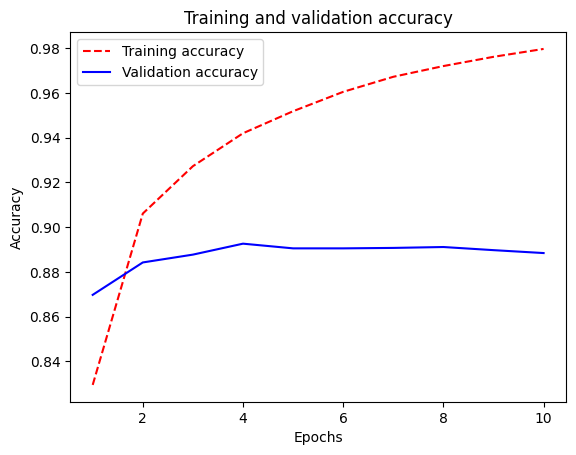

Training and validation accuracy plotted.


In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "r--", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
print("Training and validation accuracy plotted.")

In [ ]:
test_loss, test_acc = model.evaluate(bag_of_words_test_ds)
print(f"Bag-of-words test accuracy: {test_acc:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8829 - loss: 0.2902
Bag-of-words test accuracy: 0.8829


In [ ]:
max_tokens = 30_000 # Increase max_tokens for bigrams
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    split="whitespace",
    output_mode="multi_hot",
    ngrams=2, # Enable bigrams
)
text_vectorization.adapt(train_ds_no_labels)
print("TextVectorization layer for bigrams initialized and adapted.")

TextVectorization layer for bigrams initialized and adapted.


In [ ]:
bigram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)
bigram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)
bigram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)
print("Bigram datasets created for training, validation, and testing.")

Bigram datasets created for training, validation, and testing.


In [ ]:
model = build_linear_classifier(max_tokens, "bigram_classifier")
print("Bigram linear classifier model created.")

Bigram linear classifier model created.


In [ ]:
history = model.fit(
    bigram_train_ds,
    validation_data=bigram_val_ds,
    epochs=10,
    callbacks=[early_stopping],
)
print("Bigram linear classifier model training initiated.")

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - accuracy: 0.8534 - loss: 0.4305 - val_accuracy: 0.8896 - val_loss: 0.3264
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.9347 - loss: 0.2414 - val_accuracy: 0.8989 - val_loss: 0.2800
Bigram linear classifier model training initiated.


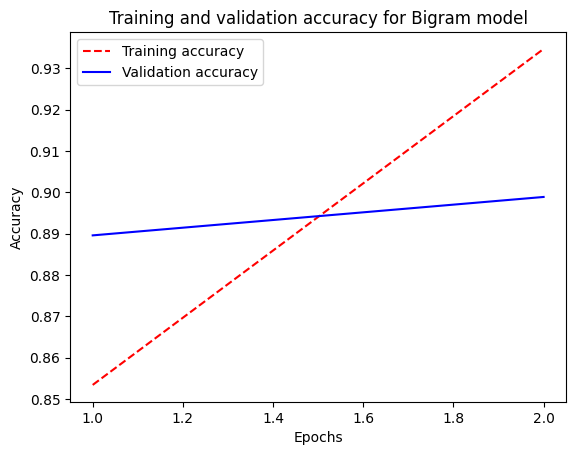

Bigram model training and validation accuracy plotted.


In [ ]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "r--", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy for Bigram model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
print("Bigram model training and validation accuracy plotted.")

In [ ]:
test_loss, test_acc = model.evaluate(bigram_test_ds)
print(f"Bigram test accuracy: {test_acc:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8904 - loss: 0.3340
Bigram test accuracy: 0.8904


In [ ]:
max_length = 150 # Cutoff reviews after 150 words.
max_tokens = 10_000 # Restrict to top 10,000 words
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    split="whitespace",
    output_mode="int", # Output integer sequences
    output_sequence_length=max_length,
)
text_vectorization.adapt(train_ds_no_labels)
print("TextVectorization layer for sequence models initialized and adapted.")

TextVectorization layer for sequence models initialized and adapted.


In [ ]:
sequence_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)
sequence_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)
sequence_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)
print("Sequence datasets created for training, validation, and testing.")

Sequence datasets created for training, validation, and testing.


## Train Recurrent Model with One-Hot Encoding

### Subtask:
Build and train a recurrent neural network (LSTM) using one-hot encoded input sequences.


**Reasoning**:
The first instruction is to define the `hidden_dim` for the LSTM layer, which is a prerequisite for building the model. This step will set the dimensionality for the LSTM units.



In [ ]:
hidden_dim = 64
print(f"Hidden dimension for LSTM set to: {hidden_dim}")

Hidden dimension for LSTM set to: 64


In [ ]:
inputs = keras.Input(shape=(max_length,), dtype="int32")
one_hot_encoding = OneHotEncoding(max_tokens)
x = one_hot_encoding(inputs)
print("Input layer and OneHotEncoding layer created and connected.")

Input layer and OneHotEncoding layer created and connected.


In [ ]:
x = layers.Bidirectional(layers.LSTM(hidden_dim))(x)
print("Bidirectional LSTM layer added.")

Bidirectional LSTM layer added.


In [ ]:
x = layers.Dropout(0.5)(x)
print("Dropout layer added.")

Dropout layer added.


In [ ]:
outputs = layers.Dense(1, activation="sigmoid")(x)
print("Dense output layer added.")

Dense output layer added.


In [ ]:
model = keras.Model(inputs, outputs, name="lstm_with_one_hot")
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
print("LSTM with one-hot encoding model created and compiled.")

LSTM with one-hot encoding model created and compiled.


In [ ]:
history = model.fit(
    sequence_train_ds,
    validation_data=sequence_val_ds,
    epochs=10,
    callbacks=[early_stopping],
)
print("LSTM with one-hot encoding model training initiated.")

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 59s 120ms/step - accuracy: 0.7096 - loss: 0.5481 - val_accuracy: 0.8218 - val_loss: 0.3943
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 55s 117ms/step - accuracy: 0.8725 - loss: 0.3204 - val_accuracy: 0.8471 - val_loss: 0.3934
LSTM with one-hot encoding model training initiated.


In [ ]:
test_loss, test_acc = model.evaluate(sequence_test_ds)
print(f"LSTM with one-hot encoding test accuracy: {test_acc:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.8112 - loss: 0.4082
LSTM with one-hot encoding test accuracy: 0.8112


## Train Recurrent Model with Learned Embedding

### Subtask:
Build and train a recurrent model (LSTM) using a trainable embedding layer to learn word representations.


**Reasoning**:
The next step is to create a Keras `Input` layer, which is the starting point for defining the recurrent model with a learned embedding.



In [ ]:
inputs = keras.Input(shape=(max_length,), dtype="int32")
print("Input layer created.")

Input layer created.


In [ ]:
x = keras.layers.Embedding(
    input_dim=max_tokens,
    output_dim=hidden_dim,
    mask_zero=True,
)(inputs)
print("Embedding layer created and connected to input.")

Embedding layer created and connected to input.


In [ ]:
x = keras.layers.Bidirectional(keras.layers.LSTM(hidden_dim))(x)
print("Bidirectional LSTM layer added.")

Bidirectional LSTM layer added.


In [ ]:
x = keras.layers.Dropout(0.5)(x)
print("Dropout layer added.")

Dropout layer added.


In [ ]:
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
print("Dense output layer added.")

Dense output layer added.


In [ ]:
model = keras.Model(inputs, outputs, name="lstm_with_embedding")
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
print("LSTM with embedding model created and compiled.")

LSTM with embedding model created and compiled.


In [ ]:
history = model.fit(
    sequence_train_ds,
    validation_data=sequence_val_ds,
    epochs=10,
    callbacks=[early_stopping],
)
print("LSTM with embedding model training initiated.")

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - accuracy: 0.7619 - loss: 0.4743 - val_accuracy: 0.8348 - val_loss: 0.4029
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.8807 - loss: 0.3045 - val_accuracy: 0.8473 - val_loss: 0.3718
LSTM with embedding model training initiated.


In [ ]:
test_loss, test_acc = model.evaluate(sequence_test_ds)
print(f"LSTM with learned embedding test accuracy: {test_acc:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8200 - loss: 0.4472
LSTM with learned embedding test accuracy: 0.8200


In [ ]:
imdb_vocabulary = text_vectorization.get_vocabulary()
tokenize_no_padding = keras.layers.TextVectorization(
    vocabulary=imdb_vocabulary,
    split="whitespace",
    output_mode="int",
)
print("IMDb vocabulary extracted and tokenize_no_padding layer initialized.")

IMDb vocabulary extracted and tokenize_no_padding layer initialized.


In [ ]:
import tensorflow as tf

context_size = 4
window_size = 9

def window_data(token_ids):
    num_windows = tf.maximum(tf.size(token_ids) - context_size * 2, 0)
    windows = tf.range(window_size)[None, :]
    windows = windows + tf.range(num_windows)[:, None]
    windowed_tokens = tf.gather(token_ids, windows)
    return tf.data.Dataset.from_tensor_slices(windowed_tokens)

def split_label(window):
    left = window[:context_size]
    right = window[context_size + 1 :]
    bag = tf.concat((left, right), axis=0)
    label = window[4]
    return bag, label

dataset = keras.utils.text_dataset_from_directory(
    imdb_extract_dir / "train", batch_size=None
)
dataset = dataset.map(lambda x, y: x, num_parallel_calls=8)
dataset = dataset.map(tokenize_no_padding, num_parallel_calls=8)
dataset = dataset.interleave(window_data, cycle_length=8, num_parallel_calls=8)
dataset = dataset.map(split_label, num_parallel_calls=8)
print("CBOW dataset prepared.")

Found 75000 files belonging to 3 classes.
CBOW dataset prepared.


In [ ]:
hidden_dim = 64
print(f"Hidden dimension for CBOW embedding set to: {hidden_dim}")

Hidden dimension for CBOW embedding set to: 64


In [ ]:
inputs = keras.Input(shape=(2 * context_size,))
cbow_embedding = layers.Embedding(
    max_tokens,
    hidden_dim,
)
x = cbow_embedding(inputs)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(max_tokens, activation="sigmoid")(x)
cbow_model = keras.Model(inputs, outputs)
cbow_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
print("CBOW model created and compiled.")

CBOW model created and compiled.


In [ ]:
dataset = dataset.batch(1024).cache()
cbow_model.fit(dataset, epochs=4)
print("CBOW model training initiated and completed.")

Epoch 1/4
16503/16503 ━━━━━━━━━━━━━━━━━━━━ 424s 26ms/step - loss: 6.0188 - sparse_categorical_accuracy: 0.0823
Epoch 2/4
   64/16503 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - loss: 5.6173 - sparse_categorical_accuracy: 0.1304

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


16503/16503 ━━━━━━━━━━━━━━━━━━━━ 46s 3ms/step - loss: 5.4980 - sparse_categorical_accuracy: 0.1374
Epoch 3/4
16503/16503 ━━━━━━━━━━━━━━━━━━━━ 50s 3ms/step - loss: 5.3780 - sparse_categorical_accuracy: 0.1430
Epoch 4/4
16503/16503 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - loss: 5.3222 - sparse_categorical_accuracy: 0.1446
CBOW model training initiated and completed.
